In [1]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback
from AnticipatoryCA import AnticipatoryCA
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


# Data Generation

In [5]:

#Seedings and Config
 
SEED =3
RULE_NUMBER=110
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
 
gridsize=10
 
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=1
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=MEMORY_CONSTANT)

ca.set_rule_number(RULE_NUMBER)
sequences= np.array(ca.generate_training_data_sequences(x_values,sequence_length=sequence_length))


 

np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
 
x_train = x_sequence
  
y_train_full= Y_val_onehot
  
loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                                            tf.reshape(y, shape=(-1, num_classes)) ,from_logits=True)
                                             
print("Data generated") 

Starting...
Data generated


In [6]:
split_ratio = 0.25
print(x_train.shape)
x_train=x_train.reshape(-1,10,1)
print(x_train.shape)
split_point_x = int(len(x_train) * split_ratio)
split_point_y = int(len(y_train_full) * split_ratio)

x_test = x_train[:split_point_x]
y_test = y_train_full[:split_point_y]
x_train = x_train[split_point_x:]
y_train = y_train_full[split_point_y:]


split_point_x = int(len(x_test) * split_ratio)
split_point_y = int(len(y_test) * split_ratio)


x_val = x_test[:split_point_x]
y_val = y_test[:split_point_x]
x_test = x_test[split_point_x:]
y_test = y_test[split_point_x:]


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


(1024, 1, 10)
(1024, 10, 1)
x_train shape: (768, 10, 1)
y_train shape: (768, 10, 2)
x_val shape: (64, 10, 1)
y_val shape: (64, 10, 2)
x_test shape: (192, 10, 1)
y_test shape: (192, 10, 2)


In [ ]:
x_train.shape

# Training heuristics  

## Removed layers



In [18]:
memory_horizon=MEMORY_CONSTANT# is equal to 1
heuristic = tf.keras.Sequential()
heuristic.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
heuristic.add(Wraparound1D(padding=1))
heuristic.add(tf.keras.layers.Conv1D(2, 3, activation='relu', padding='valid',  trainable=True) )

heuristic.add(tf.keras.layers.Conv1D(6, 1, activation='relu', padding='same'))
 
heuristic.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
heuristic.summary()
early_stopping_callback = CustomCallback()
heuristic.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=3
        , batch_size=2,callbacks=[early_stopping_callback])



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_9 (Wraparound1  (None, 12, 1)            0         
 D)                                                              
                                                                 
 conv1d_18 (Conv1D)          (None, 10, 2)             8         
                                                                 
 conv1d_19 (Conv1D)          (None, 10, 6)             18        
                                                                 
 dense_9 (Dense)             (None, 10, 2)             14        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
384/384 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.5286 - val_loss: 0.6928 - val_

# Accuracy too low  

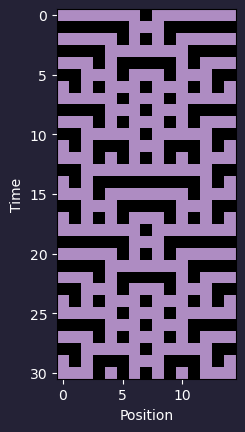

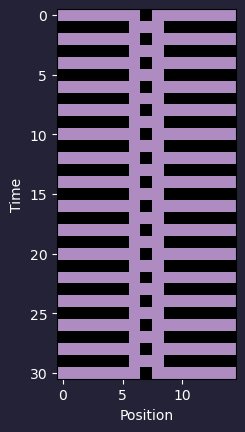

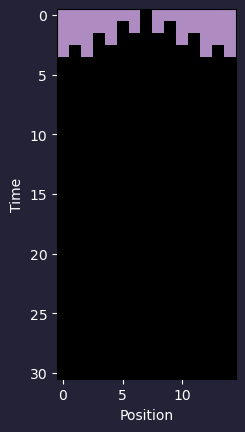

In [32]:
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
cah = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
init_state_nr=102
steps=30
#cah.set_state_reset(x_values[init_state_nr])
#ca.set_state_reset(x_values[init_state_nr])
ca.set_rule_number(RULE_NUMBER)
 
cah.set_rule_number(RULE_NUMBER)
ca.set_rule_number(RULE_NUMBER)

ca.step_multiple(steps)
cah.step_with_model(heuristic,(1,gridsize,1),steps)
figure,img=ca.render_state()
figure.savefig("rule73_heur_ca.png", dpi=300, bbox_inches='tight')
figure,img=cah.render_state()
figure.savefig("rule73_heur.png", dpi=300, bbox_inches='tight')
###################
aca=AnticipatoryCA(grid_size=gridsize,heuristic=heuristic , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
aca.set_rule_number(RULE_NUMBER)
#aca.set_state_reset(x_values[init_state_nr]) 
aca.weak_anticipation_step_multiple(steps)
figure,img=aca.render_state()
figure.savefig("rule73_heur_aca.png", dpi=300, bbox_inches='tight')

# Quantized Model

In [21]:

quantized_heuristic = tf.keras.Sequential()
quantized_heuristic.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
quantized_heuristic.add(Wraparound1D(padding=1))
quantized_heuristic.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

quantized_heuristic.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same'))
 
quantized_heuristic.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

quantized_heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
quantized_heuristic.summary()
early_stopping_callback = CustomCallback()
x_train=x_train.reshape(-1,MEMORY_CONSTANT*gridsize,1)
quantized_heuristic.fit(x_train, y_train, validation_data=(x_train, y_train), epochs=2
        , batch_size=2,callbacks=[early_stopping_callback])
 




Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_11 (Wraparound  (None, 12, 1)            0         
 1D)                                                             
                                                                 
 conv1d_22 (Conv1D)          (None, 10, 10)            40        
                                                                 
 conv1d_23 (Conv1D)          (None, 10, 10)            110       
                                                                 
 dense_11 (Dense)            (None, 10, 2)             22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
384/384 [==============================] - 1s 3ms/step - loss: 0.5917 - accuracy: 0.6874 - val_loss: 0.4513 - v

# Quantization drastically decreases accuracy

In [22]:
def round_and_convert_to_int(x):
    return np.round(x).astype(np.int32)
for indx,layer in enumerate(quantized_heuristic.layers):
    if isinstance(layer, tf.keras.layers.Conv1D) or isinstance(layer, tf.keras.layers.Dense):
        weights, biases = layer.get_weights()
        layer.set_weights([round_and_convert_to_int(weights), round_and_convert_to_int(biases)])
        quantized_heuristic.layers[indx]=layer
         
print(quantized_heuristic.evaluate(x_train,y_train))
print(quantized_heuristic.weights)

24/24 [==============================] - 0s 1000us/step - loss: 0.6931 - accuracy: 0.4714
[0.6931474208831787, 0.4713541567325592]
[<tf.Variable 'conv1d_22/kernel:0' shape=(3, 1, 10) dtype=float32, numpy=
array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  0.]],

       [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]],

       [[ 0., -1.,  0.,  1.,  1.,  0.,  0.,  0.,  1., -1.]]],
      dtype=float32)>, <tf.Variable 'conv1d_22/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'conv1d_23/kernel:0' shape=(1, 10, 10) dtype=float32, numpy=
array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.],
        [ 1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0., -1.],
        [ 1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0., -1.],
        [ 0.,  0.,  0.

# Pruned Heuristic seems to have no effect

In [27]:

import tensorflow_model_optimization as tfmot

pruned_heuristic = tf.keras.Sequential()
pruned_heuristic.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
pruned_heuristic.add(Wraparound1D(padding=1))
pruned_heuristic.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

pruned_heuristic.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same'))
 
pruned_heuristic.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

pruned_heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
pruned_heuristic.summary()
pruned_model=pruned_heuristic
begin_step = 0
end_step = 5000  


pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
                                                               final_sparsity=0.87,
                                                               begin_step=0,
                                                               end_step=end_step)
}
 
#wraparound layer removed because its a custom layer
first_layers = pruned_model.layers[:1]
original_model = tf.keras.Sequential(pruned_model.layers[1:])


original_model_pruned = tfmot.sparsity.keras.prune_low_magnitude(original_model, **pruning_params)

 
pruned_heuristic_final = tf.keras.Sequential()
for layer in first_layers:
    pruned_heuristic_final.add(layer)
    
for layer in original_model_pruned.layers:
    pruned_heuristic_final.add(layer)
    
pruning_callback = tfmot.sparsity.keras.UpdatePruningStep()
pruned_heuristic_final.compile(optimizer='adam',loss=loss,metrics=['accuracy'] )

pruned_heuristic_final.build(input_shape=(None,gridsize,1))
pruned_heuristic.fit(x_train , y_train , validation_data=(x_val, y_val), epochs=1
        , batch_size=2,callbacks=[early_stopping_callback,pruning_callback])
pruned_heuristic_final.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_16 (Wraparound  (None, 12, 1)            0         
 1D)                                                             
                                                                 
 conv1d_32 (Conv1D)          (None, 10, 10)            40        
                                                                 
 conv1d_33 (Conv1D)          (None, 10, 10)            110       
                                                                 
 dense_16 (Dense)            (None, 10, 2)             22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
384/384 [==============================] - 1s 2ms/step - loss: 0.5967 - accuracy: 0.7772 - val_loss: 0.4318 - val_accurac

In [17]:
x_train.shape

(512, 20, 1)

# Adding gaussian noise to weights can result in better heuristics

In [19]:
memory_horizon=MEMORY_CONSTANT
heuristic = tf.keras.Sequential()
heuristic.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
heuristic.add(Wraparound1D(padding=1))
heuristic.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

heuristic.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same'))
 
heuristic.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
heuristic.summary()
early_stopping_callback = CustomCallback()
x_train=x_train.reshape(-1,MEMORY_CONSTANT*gridsize,1)
heuristic.fit(x_train, y_train, validation_data=(x_train, y_train), epochs=2
        , batch_size=1,callbacks=[early_stopping_callback])
 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_2 (Wraparound1  (None, 12, 1)            0         
 D)                                                              
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 10)            40        
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 10)            110       
                                                                 
 dense_2 (Dense)             (None, 10, 2)             22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
768/768 [==============================] - 3s 3ms/step - loss: 0.5015 - accuracy: 0.8802 - val_loss: 0.3392 - va

In [24]:
noise_model=heuristic

conv_layer = noise_model.layers[-2]#[layer for layer in noise_model.layers if isinstance(layer, tf.keras.layers.Conv1D)]
acc=noise_model.evaluate(x_train,y_train)[1]
while(acc ==1 or acc <0.90):
  
    weights, biases = conv_layer.get_weights()
    noise = np.random.normal(0, 0.1, weights.shape)  
    weights_with_noise = weights + noise
    conv_layer.set_weights([weights_with_noise, biases])
    acc=noise_model.evaluate(x_test,y_test)[1]
        

print(acc)

6/6 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.9026
0.9026041626930237


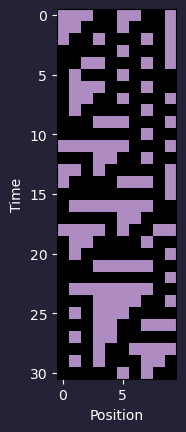

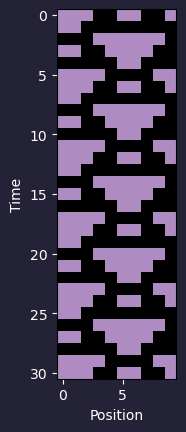

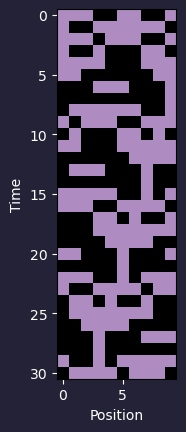

In [25]:
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=4)
cah = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
init_state_nr=102
steps=30
cah.set_state_reset(x_values[init_state_nr])
ca.set_state_reset(x_values[init_state_nr])
ca.set_rule_number(RULE_NUMBER)
 
cah.set_rule_number(RULE_NUMBER)
ca.set_rule_number(RULE_NUMBER)

ca.step_multiple(steps)
cah.step_with_model(noise_model,(1,gridsize,1),steps)
figure,img=ca.render_state()
figure.savefig("rule110_goodheur_ca.png", dpi=300, bbox_inches='tight')
figure,img=cah.render_state()
figure.savefig("rule110_goodheur.png", dpi=300, bbox_inches='tight')
###################
aca=AnticipatoryCA(grid_size=gridsize,heuristic=noise_model , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
aca.set_rule_number(RULE_NUMBER)
aca.set_state_reset(x_values[init_state_nr]) 
aca.weak_anticipation_step_multiple(steps)
figure,img=aca.render_state()


figure.savefig("rule110_goodheur_aca.png", dpi=300, bbox_inches='tight')

In [26]:
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=2
 
sequence_length=MEMORY_CONSTANT*2
 
sequences= np.array(aca.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 
 
n = gridsize
np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
 
x_train = x_sequence
y_train_full= Y_val_onehot

 

Data generated


In [27]:
split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
 
split_point_x = int(len(x_train_reshaped) * split_ratio)
split_point_y = int(len(y_train_full) * split_ratio)
 
x_test = x_train_reshaped[:split_point_x]
y_test = y_train_full[:split_point_y]
x_train = x_train_reshaped[split_point_x:]
y_train = y_train_full[split_point_y:]
split_ratio = 0.5
 
split_point_x = int(len(x_test) * split_ratio)
split_point_y = int(len(y_test) * split_ratio)

 
x_val = x_test[:split_point_x]
y_val = y_test[:split_point_x]
x_test = x_test[split_point_x:]
y_test = y_test[split_point_x:]
 
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (768, 10, 2)
y_train shape: (768, 10, 2)
x_val shape: (128, 10, 2)
y_val shape: (128, 10, 2)
x_test shape: (128, 10, 2)
y_test shape: (128, 10, 2)


# with conv

In [28]:
num_filters=1
kernel_size = MEMORY_CONSTANT
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,MEMORY_CONSTANT,1  )))  
model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                 kernel_initializer=keras.initializers.ones(), 
                                         bias_initializer=tf.keras.initializers.he_normal(),trainable=True,use_bias=True,
                                 activation="relu"
                                  ))

 
model.add(tf.keras.layers.Reshape((gridsize,1)))
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()

model.fit(x_train, y_train, 
          validation_data=(x_val, y_val)
          ,epochs=5
        , batch_size=1,callbacks=[early_stopping_callback]) 
print(f"test size {x_test.shape[0]}")
model.evaluate(x_test,y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 10, 1, 1)          3         
                                                                 
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 dense_3 (Dense)             (None, 10, 2)             4         
                                                                 
 wraparound1d_3 (Wraparound1  (None, 12, 2)            0         
 D)                                                              
                                                                 
 conv1d_7 (Conv1D)           (None, 10, 10)            70        
                                                                 
 conv1d_8 (Conv1D)           (None, 10, 10)            110       
                                                      

[0.3178861141204834, 1.0]

# with recc

In [76]:
num_filters=1
kernel_size = MEMORY_CONSTANT
model = tf.keras.Sequential()

shape=(-1,gridsize*MEMORY_CONSTANT,1)
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize*MEMORY_CONSTANT,1     )))  

model.add(tf.keras.layers.SimpleRNN (units=10, return_sequences=False, 
                               kernel_initializer=tf.keras.initializers.ones(), 
                               bias_initializer=tf.keras.initializers.he_normal()))

model.add(tf.keras.layers.Reshape((gridsize,1)))
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()

early_stopping_callback = CustomCallback()

model.fit(x_train.reshape(shape ), y_train, 
          validation_data=(x_val.reshape(shape), y_val)
          ,epochs=5
        , batch_size=1,callbacks=[early_stopping_callback]) 
print(f"test size {x_test.shape[0]}")
model.evaluate(x_test.reshape(shape ),y_test)

#print((x_train.reshape(shape )[0]))
#model.predict(x_train.reshape(shape )[0])

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_31 (SimpleRNN)   (None, 10)                120       
                                                                 
 reshape_14 (Reshape)        (None, 10, 1)             0         
                                                                 
 dense_45 (Dense)            (None, 10, 2)             4         
                                                                 
 wraparound1d_24 (Wraparound  (None, 12, 2)            0         
 1D)                                                             
                                                                 
 conv1d_49 (Conv1D)          (None, 10, 10)            70        
                                                                 
 conv1d_50 (Conv1D)          (None, 10, 10)            110       
                                                     

[0.6477356553077698, 0.63671875]